In [1]:
import os
import pickle
import random
import logging
import argparse
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from timeit import default_timer as timer
from datetime import timedelta

from models import WordEncoder, Attention, TagEmbedding, WordDecoder, MSVED, KumaMSD
from dataset import MorphologyDatasetTask3, Vocabulary

from kumaraswamy import Kumaraswamy
from hard_kumaraswamy import StretchedAndRectifiedDistribution as HardKumaraswamy

from main import *

In [2]:
def plot_kuma_samples(sample, actual, vocab):
    x_labels = list(vocab.idx_2_desc.values())

    fig, ax = plt.subplots()
    im = ax.imshow(torch.cat((sample, actual), 0).cpu())

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(['sample', 'actual'])

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    plt.show()

In [3]:
def plot_losses(language, model_id, num_points=200):

    epoch_details = pd.read_csv('../models/{}-{}/epoch_details.csv'.format(language, model_id))
    
    plt.figure()
    plt.plot(epoch_details[' ce_loss_sup'], label='ce_loss_sup')
    plt.plot(epoch_details[' kl_sup'], label='kl_sup')
    plt.plot(epoch_details[' clamp_kl_sup'], label='clamp_kl_sup')
    plt.plot(epoch_details[' kuma_loss_sup'], label='kuma_loss_sup')
    plt.plot(epoch_details[' yt_loss_sup'], label='yt_loss_sup')
    plt.legend()
    plt.ylim((-0.1, 4))
    plt.title('Sup Loss terms')
    plt.show()
    
    plt.figure()
    plt.plot(epoch_details[' ce_loss_unsup'], label='ce_loss_unsup')
    plt.plot(epoch_details[' kl_unsup'], label='kl_unsup')
    plt.plot(epoch_details[' clamp_kl_unsup'], label='clamp_kl_unsup')
    plt.plot(epoch_details[' kl_kuma_unsup'], label='kl_kuma_unsup')
    plt.ylim((-0.1, 5))
    plt.legend()
    plt.title('Unsup Loss terms')
    plt.show()

    plt.figure()
    plt.plot(epoch_details[' loss_sup'], label='loss_sup')
    plt.plot(epoch_details[' loss_unsup'], label='loss_unsup')
    plt.plot(epoch_details[' total_loss'], label='total_loss')
    plt.ylim((-0.1, 10))
    plt.legend()
    plt.title('Loss terms')
    plt.show()

In [4]:
#epoch_details.columns.values

In [5]:
# epoch_details[[' total_loss']]

In [6]:
def test_kuma(model, kumaMSD, test_loader):
    '''
    Test function
    '''
    model.eval()
    kumaMSD.eval()
    for i_batch, sample_batched in enumerate(test_loader):

        with torch.no_grad():
            x_s = sample_batched['source_form'].to(device)
            x_t = sample_batched['target_form'].to(device)
            y_t = sample_batched['msd'].to(device)

            x_s = torch.transpose(x_s, 0, 1)
            x_t = torch.transpose(x_t, 0, 1)
            y_t = torch.transpose(y_t, 0, 1)

            x_t_p, _, _ = model(x_s, x_t, y_t)
            sample, _   = kumaMSD(x_t)
            actual      = torch.sum(y_t, 0)
            
            x_t_p       = x_t_p[1:].view(-1, x_t_p.shape[-1])

            outputs     = F.log_softmax(x_t_p, dim=1).type(torch.LongTensor)
            outputs     = torch.squeeze(outputs, 1)

            target_word = ''
            for i in outputs:
                p       = np.argmax(i, axis=0).detach().cpu().item()
                entity  = idx_2_char[p]

                if   entity == '<SOS>':
                    continue
                elif entity == '<PAD>' or entity == '<EOS>':
                    break

                target_word += idx_2_char[p]
            
        return target_word, sample_batched, sample, actual, vocab

In [76]:
language = 'turkish'
model_id = '25'

In [77]:
device         = torch.device('cpu')
checkpoint     = torch.load('../models/{}-{}/model.pt'.format(language, model_id), map_location=device)

config         = checkpoint['config']
vocab          = checkpoint['vocab']

test_loader, d = initialize_dataloader(run_type='test', language=config['language'], task='sup',
                                       vocab=vocab, batch_size=1, shuffle=True)
idx_2_char     = d.idx_2_char

model, kumaMSD = initialize_model(config)
model.load_state_dict(checkpoint['model_state_dict'])
kumaMSD.load_state_dict(checkpoint['kumaMSD_state_dict'])

epoch_details = pd.read_csv('../models/{}-{}/epoch_details.csv'.format(language, model_id))

In [74]:
# plot_losses(language=language, model_id=model_id)

In [78]:
kl_sup_25= epoch_details[' kl_sup']
kl_sup_clamp_25 = epoch_details[' clamp_kl_sup']

In [56]:
kl_sup_15 = epoch_details[' kl_sup']
kl_sup_clamp_15 = epoch_details[' clamp_kl_sup']

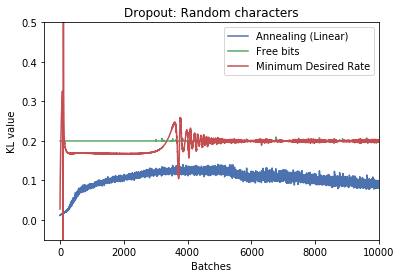

In [114]:
with plt.style.context('seaborn-deep'):

    plt.figure()

    # plt.plot(kl_sup_19, label='Vanilla')
    plt.plot(kl_sup_19, label='Annealing (Linear)')
    plt.plot(kl_sup_clamp_17, label='Free bits')
    plt.plot(kl_sup_clamp_20, label='Minimum Desired Rate')

    plt.legend()
    plt.ylim((-0.05, 0.5))
    plt.ylabel('KL value')
    plt.xlabel('Batches')
    plt.xlim((-500, 10000))
    plt.title('Dropout: Random characters')
    plt.show()

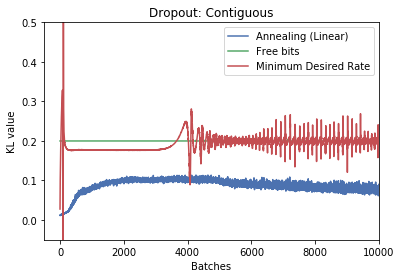

In [110]:
with plt.style.context('seaborn-deep'):

    plt.figure()
    plt.plot(kl_sup_24, label='Annealing (Linear)')
    plt.plot(kl_sup_clamp_15, label='Free bits')
    plt.plot(kl_sup_clamp_25, label='Minimum Desired Rate')

    plt.legend()
    plt.ylim((-0.05, 0.5))
    plt.xlim((-500, 10000))
    plt.xlabel('Batches')
    plt.ylabel('KL value')
    plt.title('Dropout: Contiguous')
    plt.show()

In [ ]:
target_word, info, sample, actual, vocab = test_kuma(model, kumaMSD, test_loader)

print('Source          : {}'.format(info['source_str']))
print('MSD             : {}'.format(info['msd_str']))
print('Target          : {}'.format(info['target_str']))
print("Predicted target: ['{}']".format(target_word))

plot_kuma_samples(sample, actual, vocab)

In [ ]:
print(kumaMSD)
print(kumaMSD.ai.weight.size())

In [ ]:
# print(kumaMSD.ai.weight[0])
# print(kumaMSD.bi.weight)

# a = 0.1 + torch.sigmoid(kumaMSD.ai)     * 0.8
# b = 1   + torch.sigmoid(kumaMSD.bi - 5) * 5

# for param in kumaMSD.parameters():
#     print(param.size())

In [ ]:
loss_sup_yt = nn.BCELoss(reduction='mean')

a = torch.tensor([[0.0000, 0.1774, 0.6398, 0.6107, 1.0000, 0.4144, 0.4772, 0.6340, 0.0000,
         1.0000, 0.0000, 0.1173, 0.0256, 0.0115, 1.0000, 0.7065, 0.6073, 0.0992,
         0.0559, 0.9018, 0.0000, 0.9181, 0.7658, 0.9906, 0.7000, 0.8970, 0.7419,
         0.0000, 0.7092, 1.0000, 0.1014, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.4946, 0.8719, 0.7733, 0.0645, 1.0000, 0.4008,
         0.1611, 0.5172, 1.0000, 0.0000, 0.0000, 0.0131, 0.2254, 0.4259, 1.0000,
         0.9937, 0.2112, 1.0000, 0.7008, 0.8460, 1.0000, 0.5059, 0.7482, 0.8534,
         0.7763, 0.3843, 0.8723, 0.1525, 0.2357]])

b = torch.tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

print(loss_sup_yt(a, b))

In [ ]:
a1 = torch.tensor([[0.0000, 0.1774, 0.6398, 0.6107, 1.0000, 0.4144, 0.4772, 0.6340, 0.0000,
         1.0000, 0.0000, 0.1173, 0.0256, 0.0115, 1.0000, 0.7065, 0.6073, 0.0992,
         0.0559, 0.9018, 0.0000, 0.9181, 0.7658, 0.9906, 0.7000, 0.8970, 0.7419,
         0.0000, 0.7092, 1.0000, 0.1014, 1.0000]])

b1 = torch.tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

print(loss_sup_yt(a1, b1))


a2 = torch.tensor([[0.0000, 1.0000, 0.0000, 0.4946, 0.8719, 0.7733, 0.0645, 1.0000, 0.4008,
         0.1611, 0.5172, 1.0000, 0.0000, 0.0000, 0.0131, 0.2254, 0.4259, 1.0000,
         0.9937, 0.2112, 1.0000, 0.7008, 0.8460, 1.0000, 0.5059, 0.7482, 0.8534,
         0.7763, 0.3843, 0.8723, 0.1525, 0.2357]])

b2 = torch.tensor([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

print(loss_sup_yt(a2, b2))

print(loss_sup_yt(a1, b1) + loss_sup_yt(a2, b2))

In [ ]:
with open('../models/turkish-31/epoch_details.csv', 'r') as f:
    source = f.read()
    
out        = []
sentences  = source.strip().split('\n')
num        = 0

for sentence in sentences:
    if num % 100 == 0:
        out.append(sentence)
    num += 1
        
with open('./epoch_details.csv', 'w+') as f:
    f.write('\n'.join(out))

### Kuma MSD

In [ ]:
from kuma_msd_main import initialize_model

language = 'turkish'
model_id = '3'

device         = torch.device('cpu')
checkpoint     = torch.load('../models/kumamsd_{}-{}/model.pt'.format(language, model_id), map_location=device)

config         = checkpoint['config']
vocab          = checkpoint['vocab']

test_loader, d = initialize_dataloader(run_type='test', language=config['language'], task='sup',
                                       vocab=vocab, batch_size=1, shuffle=True)
idx_2_char     = d.idx_2_char

kumaMSD = initialize_model(config)
kumaMSD.load_state_dict(checkpoint['model_state_dict'])



In [ ]:
def test_kumaMSD(kumaMSD, test_loader):
    '''
    Test function
    '''
    kumaMSD.eval()
    for i_batch, sample_batched in enumerate(test_loader):

        with torch.no_grad():
            x_s = sample_batched['source_form'].to(device)
            x_t = sample_batched['target_form'].to(device)
            y_t = sample_batched['msd'].to(device)

            x_s = torch.transpose(x_s, 0, 1)
            x_t = torch.transpose(x_t, 0, 1)
            y_t = torch.transpose(y_t, 0, 1)

            sample, _   = kumaMSD(x_t)
            actual      = torch.sum(y_t, 0)
            
        return sample_batched, sample, actual

In [ ]:
sample_batched, sample, actual = test_kumaMSD(kumaMSD, test_loader)

plot_kuma_samples(sample, actual, vocab)

In [ ]:
epoch_details = pd.read_csv('../models/kumamsd_{}-{}/epoch_details.csv'.format(language, model_id))

In [ ]:
epoch_details.columns.values

print(epoch_details[440:480])

In [ ]:
plt.plot(epoch_details[' loss'][:4000])

In [ ]:
def plot_losses(language, model_id, num_points=200):

    epoch_details = pd.read_csv('../models/kumamsd_{}-{}/epoch_details.csv'.format(language, model_id))
    
    plt.figure()
    plt.plot(epoch_details[' ce_loss_sup'], label='ce_loss_sup')
    plt.plot(epoch_details[' kl_sup'], label='kl_sup')
    plt.plot(epoch_details[' clamp_kl_sup'], label='clamp_kl_sup')
    plt.plot(epoch_details[' kuma_loss_sup'], label='kuma_loss_sup')
    plt.plot(epoch_details[' yt_loss_sup'], label='yt_loss_sup')
    plt.legend()
    plt.ylim((-0.1, 4))
    plt.title('Sup Loss terms')
    plt.show()
    
    plt.figure()
    plt.plot(epoch_details[' ce_loss_unsup'], label='ce_loss_unsup')
    plt.plot(epoch_details[' kl_unsup'], label='kl_unsup')
    plt.plot(epoch_details[' clamp_kl_unsup'], label='clamp_kl_unsup')
    plt.plot(epoch_details[' kl_kuma_unsup'], label='kl_kuma_unsup')
    plt.ylim((-0.1, 5))
    plt.legend()
    plt.title('Unsup Loss terms')
    plt.show()

    plt.figure()
    plt.plot(epoch_details[' loss_sup'], label='loss_sup')
    plt.plot(epoch_details[' loss_unsup'], label='loss_unsup')
    plt.plot(epoch_details[' total_loss'], label='total_loss')
    plt.ylim((-0.1, 10))
    plt.legend()
    plt.title('Loss terms')
    plt.show()

### Semi supervision experiments

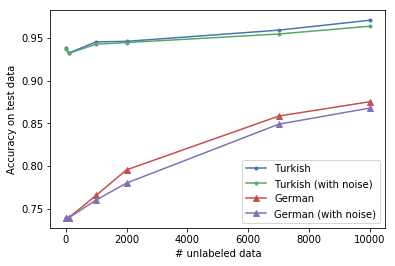

In [19]:
x          = [0, 100, 1000, 2000, 7000, 10000]

acc_turkish = [0.93875, 0.9325, 0.94562, 0.94625, 0.95938, 0.97102]
acc_turkish_noise = [0.93785, 0.9321, 0.9429, 0.9448, 0.95487, 0.964]
acc_german  = [0.73902, 0.73924, 0.76543, 0.79543, 0.85854, 0.87544]
acc_german_noise = [0.73902, 0.7390, 0.7600, 0.7799, 0.849, 0.868]

with plt.style.context('seaborn-deep'):

    plt.figure()
    plt.xlabel('# unlabeled data')
    plt.ylabel('Accuracy on test data')
    plt.plot(x, acc_turkish, label='Turkish', marker='.')
    plt.plot(x, acc_turkish_noise, label='Turkish (with noise)', marker='.')
    plt.plot(x, acc_german, label='German', marker='^')
    plt.plot(x, acc_german_noise, label='German (with noise)', marker='^') 
    
    plt.legend()
    plt.show()
    

### Suffix inflection

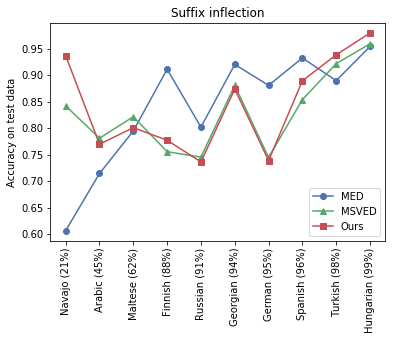

In [170]:
languages = ['Arabic', 'Finnish', 'Georgian', 'German', 'Hungarian', 'Maltese', 'Navajo', 'Russian', 'Spanish', 'Turkish']
x         = [0.4553147575, 0.886185605, 0.9499691802, 0.9554365292, 0.9991989586, 
             0.6225725095, 0.2156510374, 0.910454156, 0.9644982993, 0.9867093035]

acc_ours  = [0.76991, 0.7775, 0.87428, 0.73902, 0.97999, 0.80125, 0.93723, 0.73655, 0.88982, 0.93875]
acc_msved = [0.78132, 0.75591, 0.881, 0.74489, 0.95948, 0.82183, 0.84239, 0.74551, 0.85417, 0.92212]
acc_med   = [0.7147, 0.91156, 0.92065, 0.88111, 0.95463, 0.79495, 0.60671, 0.80229, 0.93283, 0.89004]

x_sorted = sorted(x, key=abs)

languages_sorted = []
acc_ours_sorted  = []
acc_msved_sorted = []
acc_med_sorted   = []

for i in x_sorted:
    idx = x.index(i)
    languages_sorted.append(languages[idx])
    acc_ours_sorted.append(acc_ours[idx])
    acc_msved_sorted.append(acc_msved[idx])
    acc_med_sorted.append(acc_med[idx])
    
labels = []

for i,l in enumerate(languages_sorted):
    current = l + ' ({}%)'.format(int(x_sorted[i] * 100))
    labels.append(current)

with plt.style.context('seaborn-deep'):

    plt.figure()
    plt.ylabel('Accuracy on test data')
    plt.plot(languages_sorted, acc_med_sorted,   marker='o', label='MED')
    plt.plot(languages_sorted, acc_msved_sorted, marker='^', label='MSVED')
    plt.plot(languages_sorted, acc_ours_sorted,  marker='s', label='Ours')
    plt.legend()
    plt.title('Suffix inflection')
    plt.xticks(languages_sorted, labels, rotation='vertical')
    plt.show()
    